# Decision Trees

**Decision Trees** are versatile algorithms that can perform **both classification and regression** tasks, and **even multioutput** tasks. They are powerful algorithms, capable of fitting complex datasets and they are the fundamental components of Random Forests. Decision Trees are **intuitive**, and their decisions are **easy to interpret**. Such models are often called **white box models**. In contrast, Neural Networks are generally considered **black box models**. Neural Networks make great predictions, but it is usually **hard to explain in simple terms why the predictions were made**. Conversely, Decision Trees provide **nice, simple classification rules that can even be applied manually if needed**. At the same time, finding an "optimal" decision tree for a set of training data is computationally a **very hard problem**. We will get around this by trying to build a **good-enough tree**, rather than an optimal one, although for large datasets this can still be a lot of work. More important, it is very easy (and very bad) to build decision trees that are **overfitted** to the training data, and that don’t generalize well to unseen data.

## Definition

A decision tree is a tree data structure to represent **a number of possible decision paths and an outcome for each path**. For example:

![](images/soccer.png)


Suppose we want to decide if today we will play soccer or not. We start at the **root node**, it asks about weather. If it a sunny day, then we move down to the left **child node**. It asks for the humidity. If it is a normal day, the we move down to the next node, which is a **leaf node** (no other child nodes), so it does not ask questions, it gives the answer (yes, we will play). We define a tree node to be either: 

- a **leaf node**, that predicts a single value 

- a **split node** containing an attribute to split on, a list of subtrees for specific values of that attribute, and possibly a default value to use if we see an unknown value.

In [1]:
class Leaf():
    def __init__(self, value):
        self.value = value

class Split():
    def __init__(self, attribute, subtree, default_value):
        self.attribute = attribute
        self.subtrees = subtree
        self.default_value = default_value

With this representation our soccer tree would look like:

In [3]:
cloudy = Leaf('Yes')
sunny = Split('humidity', { 'high': Leaf('No'), 'normal': Leaf('Yes') }, None)
rainy = Split('wind', { 'strong': Leaf('No'), 'weak': Leaf('Yes') }, None)
play_soccer = Split('weather', { 'sunny': sunny, 'cloudy': cloudy, "rainy": rainy }, None)


Given such a representation, we can classify an input with:

In [4]:
def classify(tree, input):

    if isinstance(tree, Leaf):
        return tree.value
    
    subtree_key = dict.get(input, tree.attribute)
    if subtree_key not in tree.subtrees:   
        return tree.default_value          
    subtree = tree.subtrees[subtree_key]   
    
    return classify(subtree, input)

In [6]:
day_1 = {'weather': 'sunny', 'humidity': 'normal', 'wind': 'weak'}
day_2 = {'weather': 'sunny', 'humidity': 'high', 'wind': 'weak'}

print(classify(play_soccer, day_1))
print(classify(play_soccer, day_2))

Yes
No


We can traverse all the tree in order to show it:

In [8]:
def show(tree, step=0):

    if isinstance(tree, Leaf):
        print((step+1)*'\t' + tree.value)
        return
    
    print(step*'\t' + '[' + tree.attribute + ']')
    step = step+1
    
    for key, subtree in tree.subtrees.items():
        print(step*'\t' + ' -> ' + key)
        show(subtree, step+1)
    return

show(play_soccer)

[weather]
	 -> sunny
		[humidity]
			 -> high
					No
			 -> normal
					Yes
	 -> cloudy
			Yes
	 -> rainy
		[wind]
			 -> strong
					No
			 -> weak
					Yes


In general, decision trees represent **an OR of AND of constraints on the attribute values** of instances. Each path from the tree root to a leaf corresponds to aa AND of attribute tests, and the tree itself to an OR of these conjunctions. For example, the decision tree about playing soccer corresponds to the expression

(weather = sunny AND humidity = normal)

OR (weather = cloudy)

OR (weather = rainy AND wind = weak)

Although decision tree have been developed with somewhat differing capabilities and requirements, decision tree learning is generally best suited to problems with the following characteristics:

- instances are described by a fixed set of attributes (e.g., temperature) and each attribute can takes a small number of disjoint possible values (e.g., hot, mild, cold). However, extensions allow handling real-valued attributes as well; 

- the target function has discrete output values. However, extension allows learning target functions with real-valued outputs

- training data may contain errors or may contain missing attribute values Decision tree are robust to errors

Many practical problems fits these characteristics, and decision tree has therefore been applied to problems such as learning to classify medical patients by their disease, equipment malfunctions by their cause, and loan applicants by their likelihood of defaulting on payments.

## Knowledge acquisition problem

We can use a Decision Tree to **encode the knowledge of an expert in a particular domain**. For example, think about another toy example: how to decide whether to wait for a table at a restaurant (in that case we are the experts). First, we need to identify the list the **attributes that we consider important to make the decision**. For example:
- Alternate: whether there is an alternative restaurant nearby
- Bar: whether the restaurant has a comfortable bar area to wait in
- Fri/Sat: true on Fridays and Saturdays
- Hungry: whether we are hungry
- Patrons: how many people are in the restaurant (values are None, Some, and Full)
- Raining: whether it is raining outside
- Price: the restaurant's price range (£, ££, £££)
- Reservation: whether we made a reservation
- Type: the kind of restaurant (French, Italian, Thai, or burger)
- WaitEstimate: the wait estimated by the host (0-10 minutes, 10-30, 30-60, or >60)

Then we can try to design a decision tree, by inserting our experience into del Decision Tree, and we can come up with the following solution:

![](images/restaurant-example.png)

We can implement the knowledge of the expert using our tree structure: 

In [9]:
no_reserved = Split('Bar', { 'No': Leaf('No'), 'Yes': Leaf('Yes') }, None)
hungry_with_alternative = Split('Raining', { 'No': Leaf('No'), 'Yes': Leaf('Yes') }, None)

no_alternative = Split('Reservation', { 'No': no_reserved, 'Yes': Leaf('Yes') }, None)
some_alternative = Split('Fri/Sat', { 'No': Leaf('No'), 'Yes': Leaf('Yes') }, None)
hungry = Split('Alternative', { 'No': Leaf('Yes'), 'Yes': hungry_with_alternative }, None)

mid_wait = Split('Alternate', { 'No': no_alternative, 'Yes': some_alternative }, None)
low_wait = Split('Hungry', { 'No': Leaf('Yes'), 'Yes': hungry }, None)

full = Split('WaitEstimate', { '60-more': Leaf('No'), '30-60': mid_wait, "10-30": low_wait, "0-10": Leaf('Yes')  }, None)

wait_restaurant = Split('Patrons', { 'None': Leaf('No'), 'Some': Leaf('Yes'), "Full": full }, None)

In [10]:
show(wait_restaurant)

[Patrons]
	 -> None
			No
	 -> Some
			Yes
	 -> Full
		[WaitEstimate]
			 -> 60-more
					No
			 -> 30-60
				[Alternate]
					 -> No
						[Reservation]
							 -> No
								[Bar]
									 -> No
											No
									 -> Yes
											Yes
							 -> Yes
									Yes
					 -> Yes
						[Fri/Sat]
							 -> No
									No
							 -> Yes
									Yes
			 -> 10-30
				[Hungry]
					 -> No
							Yes
					 -> Yes
						[Alternative]
							 -> No
									Yes
							 -> Yes
								[Raining]
									 -> No
											No
									 -> Yes
											Yes
			 -> 0-10
					Yes


And we can ask the tree to get expert answer in some cases:

In [11]:
day = {
       'Alternate': 'No', 
       'Bar': 'Yes', 
       'Fri/Sat': 'No', 
       'Hungry': 'Yes', 
       'Patrons': 'Full', 
       'Price': '$$$', 
       'Raining': 'No', 
       'Reservation': 'No', 
       'Type': 'French', 
       'WaitEstimate': '30-60'
       }
       
print(classify(wait_restaurant, day))

Yes


Designing, debugging, and maintaining rules defined by experts is **really difficult** and in some cases even **impossible**. Knowledge possessed by experts is complex as most of **it is tacit**, and hence cannot be captured without converting tacit knowledge to explicit knowledge (**externalization**), which is very difficult. In addition, this process is **time-consuming, expensive and error-prone**: the knowledge engineer may **misunderstand** the expert, or the expert may **not be able to articulate his knowledge**.

What we can have instead is **a dataset with examples** that we can leverage to find rules. In the restaurant toy example, we can have a list of past decisions that we made in different situations. An example consists of an (X,y) pair, where X is a vector of values for the input attributes and y is a single boolean output value.

In [12]:
import pandas as pd

data_set = pd.read_csv('data/restaurant.csv', keep_default_na=False)
data_set.index += 1 
data_set.head(12)

,Alternate,Bar,Fri/Sat,Hungry,Patrons,Price,Raining,Reservation,Type,WaitEstimate,Wait
1,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
2,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
3,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
4,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
5,Yes,No,Yes,No,Full,$$$,No,Yes,French,60-more,No
6,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
7,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
8,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
9,No,Yes,Yes,No,Full,$,Yes,No,Burger,60-more,No
10,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [13]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 1 to 12
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Alternate     12 non-null     object
 1   Bar           12 non-null     object
 2   Fri/Sat       12 non-null     object
 3   Hungry        12 non-null     object
 4   Patrons       12 non-null     object
 5   Price         12 non-null     object
 6   Raining       12 non-null     object
 7   Reservation   12 non-null     object
 8   Type          12 non-null     object
 9   WaitEstimate  12 non-null     object
 10  Wait          12 non-null     object
dtypes: object(11)
memory usage: 1.2+ KB


How we can devise a Decision Tree from the set of examples? Intuitively, we have to create **a tree consistent with the examples** and **as small as possible**. Unfortunately, this is an **intractable problem**. However, we can find a **good approximate** solution adopting a **divide-and-conquer approach**. The strategy is **test the "most important attribute"** (the one that makes the most difference to the classification) first, in order to divide the problem into smaller sub-problems that can then be solved recursively. But, **what is an "important" attribute?** Let's consider "Type" and "Patrons" in the toy example:

![](images/type-patrons.png)

Notice that "Type" is a poor attribute, it leaves us with four possible outcomes and each of them has the same number of positive as negative examples. Instead, "Patrons" is a fairly important attribute: if its value is "None" or "Some", we have only examples we can answer definitively, if its value is "Full" we have a mixed set of examples.

We need to partition the inputs into lists based on the specified attribute:

In [14]:
from collections import defaultdict
import numpy as np

def create_partition(inputs, attribute):
    partition = []
    keys = np.unique(inputs[attribute])
    for key in keys:
        partition.append(inputs[inputs[attribute] == key])
    return keys, partition

We can obtain the partition using the Type attribute, as in the previous example:

In [16]:
keys, partition = create_partition(data_set, 'Type')
for key, subset in zip(keys, partition):
    print("Key: ", key)
    print(subset['Wait'])
    print()

Key:  Burger
3     Yes
7      No
9      No
12    Yes
Name: Wait, dtype: object

Key:  French
1    Yes
5     No
Name: Wait, dtype: object

Key:  Italian
6     Yes
10     No
Name: Wait, dtype: object

Key:  Thai
2      No
4     Yes
8     Yes
11     No
Name: Wait, dtype: object



We obtain the four subset as in figure.

## Measuring attribute importance

In order to build a decision tree from a dataset, we need to decide **what questions to ask and in what order**. At each stage of the tree there are some possibilities we’ve eliminated and some that we haven’t. Each possible question partitions the remaining possibilities according to its answer. Ideally, we’d like to choose questions whose answers give a lot of information about what our tree should predict. If there’s a single yes/no question for which "yes" answers always correspond to Yes outputs and "no" answers to No outputs (or vice versa), this would be an awesome question to pick. Conversely, a yes/no question for which neither answer gives you much new information about what the prediction should be is probably not a good choice.

We capture the notion of "how much information" with the [**entropy** concept](https://machinelearningmastery.com/what-is-information-entropy/) (from Shannon’s information theory), that we use to represent the **uncertainty associated with data**. Imagine we have a set $S$ of data, each member of which is labeled as belonging to one of a finite number of classes $C_1, C_2, ..., C_n$. If all the data points belong to a single class, then there is no real uncertainty, which means we’d like there to be low entropy. If the data points are evenly spread across the classes, there is a lot of uncertainty and we’d like there to be high entropy. If $p_i$ is the proportion of data labeled as class $C_i$, then we can define entropy as:

$\displaystyle H(S) = -p_1 \text{log}_2 p_1 - p_2 \text{log}_2 p_2 - ... - p_n \text{log}_n p_n = -\sum\limits_{i=1}^{n}{p_ilog_2p_i}$

In order to understand this concept, let's plot the graph of a single term as the proportion of data varies:

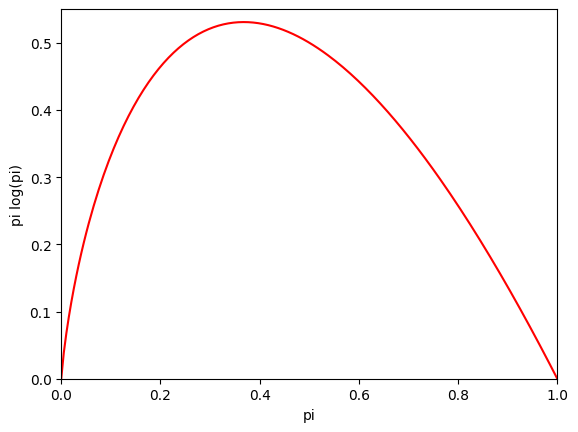

In [4]:
import numpy as np
import matplotlib.pyplot as plt

pi = np.linspace(0.0001, 1, 200)
pi_log_pi = -pi * np.log2(pi)

plt.plot(pi, pi_log_pi, "r-")
plt.xlabel("pi")
plt.ylabel("pi log(pi)")

plt.axis([0, 1, 0, 0.55])
plt.show()

The entropy is small when $p$ is close to 0 or 1 (i.e., when most of the data is in this single class), and it will be larger when $p$ is not close to 0 or 1 (i.e., when the data is spread across multiple classes). This is exactly the behavior we desire. Let's try: 

In [18]:
def entropy(p):
    return np.sum(-p * np.log2(p))

In [19]:
print(entropy(np.array([1.0])))
print(entropy(np.array([0.5, 0.5])))
print(entropy(np.array([0.25, 0.75])))

0.0
1.0
0.8112781244591328


Our data will consist of pairs (input, label), which means that we’ll need to compute the class probabilities.

In [20]:
def class_probabilities(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total_count = counts.sum()
    return counts / total_count

The we can calculate the entropy of the entire dataset:

In [21]:
def data_entropy(inputs, label):
    return entropy(class_probabilities(inputs[label]))

In [22]:
data_entropy(data_set, 'Wait')

1.0

What we’ve done is compute the entropy ("uncertainty") of a set of labeled data. Now, each stage of a decision tree involves asking a question whose answer partitions data into several subsets. Correspondingly, we’d like **some notion of the entropy that results from partitioning a set of data in a certain way**. We want a partition to have low entropy if it splits the data into subsets that themselves have low entropy, and high entropy if it contains subsets that have high entropy. Mathematically, if we partition our data $S$ into subsets $S_1, S_2,..., S_m$ containing proportions $q_1, q_2,..., q_m$ of the data, then we can compute the entropy of the partition as a weighted sum:

$\displaystyle H = q_1 H(S_1) + q_2 H(S_2) + ... + q_m H(S_m) = \sum\limits_{i=1}^{m}{q_i H(S_i)}$

In [23]:
def partition_entropy(inputs, attribute, label):
    keys, partition = create_partition(inputs, attribute)
    total_count = np.sum([subset.size for subset in partition]) 
    return keys, partition, np.sum([subset.size / total_count * data_entropy(subset, label) for subset in partition])

We can calculate the remaining entropy after the selection of "Type" and "Patrons" attributes:

In [24]:
_, _, entropy_after_type = partition_entropy(data_set, "Type", "Wait")
_, _, entropy_after_patrons = partition_entropy(data_set, "Patrons", "Wait")

print("Entropy after partitioning using Patrons attribute: ", entropy_after_patrons)
print("Entropy after partitioning using Type attribute: ", entropy_after_type)

Entropy after partitioning using Patrons attribute:  0.4591479170272448
Entropy after partitioning using Type attribute:  1.0


As expected, "Type" is a bad attribute and it leaves the entropy as before, instead "Patrons" is a good attribute and the entropy in reduced. A perfect attribute should leave a partition with no entropy, we can use as perfect attribute the label:

In [25]:
_, _, entropy_after_wait = partition_entropy(data_set, "Wait", "Wait")
print("Entropy after partitioning using a perfect attribute: ",entropy_after_wait)

Entropy after partitioning using a perfect attribute:  0.0


Another way to measure of the importance of an attribute is the **gini notion**, defined as:

$\displaystyle G_i=1-\sum\limits_{k=1}^{n}p^{2}_{i,k}$

where $p_{i,k}$ is the ratio of class k instances among the training instances in the i node.  A node is defined **pure (gini=0)** if **all training instances it applies to belong to the same class**.

XXX qualcosa di più su Gini e magari un grafico XXX

## ID3 Algorithm

The [**Iterative Dichotomiser 3** (ID3))](https://link.springer.com/article/10.1007/BF00116251) is a **greedy** algorithm that at each step selects **the most immediately best attribute** that can split the dataset into subsets with minimum entropy. It is greedy, because **there may be a better tree with a worse-looking first move**. If so, this algorithm won’t find it. Nonetheless, it is relatively easy to understand and implement.

![](images/id3.png)


In [ ]:
def id3(inputs, attributes, target, default_value='No'):
    
    # if we don't have any data, return a leaf node with the most common value of the target attribute in the dataset
    if inputs.empty:
        return Leaf(default_value)

    # find the most common value of the target attribute in the dataset
    unique_values, counts = np.unique(inputs[target], return_counts=True)
    most_common_value_index = np.argmax(counts)
    most_common_value = unique_values[most_common_value_index]

    # if the data all have the same label, we can create a leaf node 
    if len(unique_values) == 1:
        return Leaf(most_common_value)
    
    # if the list of attributes is empty, create a leaf node
    if not attributes:
        return Leaf(most_common_value)

    # create a partition for each attribute
    partitions = {attribute: partition_entropy(inputs, attribute, target) for attribute in attributes}

    # Find the partition with the lowest entropy
    best_attribute, (keys, best_partition, best_score) = min(partitions.items(), key=lambda x: x[1][2])

    # Remove the best attribute and recur on each subset
    new_attributes = attributes[attributes != best_attribute]
    
    # Recur on each subset of the best partition using the remaining attributes
    subtrees = {key: id3(subset, new_attributes, target) for key, subset in zip(keys, best_partition)}
    
    # create the node
    return Split(best_attribute, subtrees, default_value=most_common_value)

We can try our algorith with a toy dataset:

In [30]:
predictors = data_set.drop("Wait", axis=1)

tree = id3(data_set, predictors.columns.array, 'Wait')

In [31]:
show(tree)

[Patrons]
	 -> Full
		[Hungry]
			 -> No
					No
			 -> Yes
				[Type]
					 -> Burger
							Yes
					 -> Italian
							No
					 -> Thai
						[Fri/Sat]
							 -> No
									No
							 -> Yes
									Yes
	 -> None
			No
	 -> Some
			Yes


Notice that the set of examples is crucial for constructing the tree. The learned tree is different from the original one that we designed by hands. The algorithm **looks at the examples, not at the correct function**. Its hypothesis is consistent with all the examples, and it is considerably simpler than the original one. For example, the learner has no reason to tests for "raining" or "reservation2, because it can classify all the examples without these attributes.  It is also bound to make mistakes for cases with no examples: it has no cases with "wait" is 0-10 min but the restaurant is full, in that case it says not to wait when "hungry" is false but the real user would certainly wait. With more training examples the learning program could correct this mistake.

ID3 can be characterized as **searching a space of hypotheses** for one that fits the training examples. The hypothesis space searched is the set of possible decision trees. ID3 performs a simple-to-complex, hill-climbing search through this hypothesis space, beginning with the empty tree, then considering progressively more elaborate hypotheses in search of a decision tree that correctly classifies the training data. The evaluation function that guides this hill-climbing search is the entropy reduction measure: 



## CART Algorithm

The **Classification and Regression Tree (CART)** algorithm splits a set into two subsets using an attribute $k$ and a threshold $t_k$. It searches for the pair $(k,t_k)$ that produces the **purest subsets** (weighted by their size). As an example, given a dataset with two inputs of height in centimeters and weight in kilograms, the output of sex as male or female will be classified as:: 

![](images/cart-example.png)

Once the algorithm has splitted the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches a maximum depth, or if it cannot find a split that will reduce impurity. 

This is the cost function that CART tries to minimize:

$\displaystyle J(k,t_k)=\frac{m_\text{left}}{m}G_\text{left}+\frac{m_\text{right}}{m}G_\text{right}$

where $G_\text{left/right}$ measures the impurity of the left/right subset and $m_\text{left/right}$ is the number of instances in the left/right subset. 

Gini and Entropy lead to similar trees. Gini impurity is **slightly faster to compute**, while entropy tends to produce **slightly more balanced trees**.

SciKitLearn features a **DecisionTreeClassifier** class. It is a binary decision tree based on the CART algorithm able to manage continuous data value (and not only categorical as our naive implementation of ID3). We can make an example for the Iris dataset: 

In [41]:
import sklearn
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [42]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

The class features the possibility to plot the learned tree:

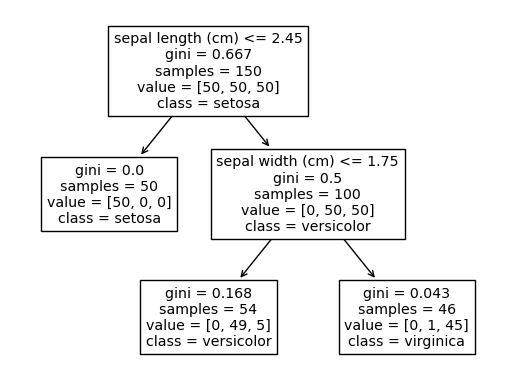

In [43]:
sklearn.tree.plot_tree(tree_clf, feature_names=iris.feature_names, class_names=iris.target_names);

Notice that the information of each nodes are: the parameter and the threashold considered, the number of training instances it applies to the node (samples), the number of training instances of each class this node applies (value), the measure of impurity (gini) and the class predicted (class). We can draw the decision boundaries:

In [44]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

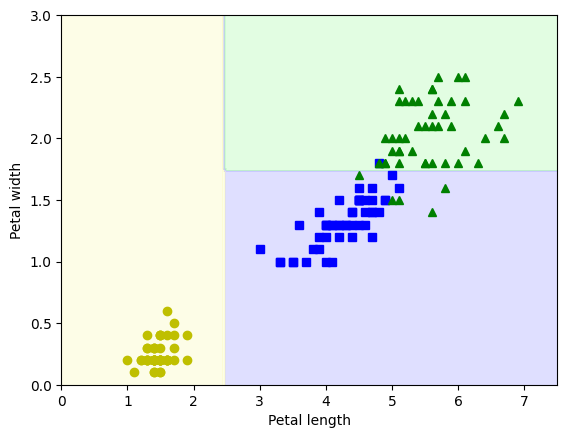

In [45]:
plot_decision_boundary(tree_clf, X, y, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.show()

The tree can also **estimate the probability that an instance belongs to a particular class**. First we traverses the tree to find the leaf node for this instance, and then we returns the ratio of training instances of the class in this node. For example, we can check a flower whose petals are 5cm long and 1.5cm wide:

In [47]:
print("Class probabilities: ", tree_clf.predict_proba([[5, 1.5]]))
print("Predicted class: ", tree_clf.predict([[5, 1.5]]))

Class probabilities:  [[0.         0.90740741 0.09259259]]
Predicted class:  [1]


Also  CART algorithm is a **greedy algorithm**: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s **reasonably good**, but **not guaranteed to be optimal**. Unfortunately, finding the optimal tree is known to be an [**NP-Complete problem**](https://www.youtube.com/watch?v=YX40hbAHx3s). So, it requires $O(exp(m))$ time, making the problem intractable even for small training sets. Instead, making predictions requires traversing the tree from the root to a leaf, which requires going through roughly $O(log_2(m))$ nodes. So predictions are very fast, even when dealing with large training sets.

## Regularization

Decision Trees make **very few assumptions** about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, **most likely overfitting it**, even learning pattern in the noise.

For Example, if we try to predict "when a roll of a dice will come up as 6 or not", we can run several experiments with several dice attributes (e.g. color, weight of the dice, time of the roll, and whether the experimenters had their fingers crossed). Of course, this is a random process which is impossible to predict using those feature, however the algorithm **will learn any pattern it can find in the input**! If there are 2 rolls of a 7gr blue dice with fingers crossed both with 6, then it may construct a tree that predicts 6 in that case...

Such a model is often called a **non-parametric model**, not because it does not have any parameters (it often has a lot) but because **the number of parameters is not determined prior to training**, so the **model structure is free to stick closely to the data**. In contrast, a **parametric model**, such as a linear model, has a predetermined number of parameters, so **its degree of freedom is limited**, reducing the risk of overfitting (but increasing the risk of underfitting). 

To avoid overfitting, we need to restrict the freedom during training. We can exploit several parameters that restrict the shape of the tree: 
- **max_depth**: the maximum depth of the tree
- **max_leaf_nodes**: the maximum number of leaf nodes
- **max_features**: the maximum number of features that are evaluated for splitting at each node 

Other algorithms work by first training the tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the [$\chi^2$ test](https://en.wikipedia.org/wiki/Chi-squared_test), are used to estimate the probability that the improvement is purely the result of chance.

As an example, we can train two trees (one with the default hyperparameters values and one with max_depth=2) over the [**moons dataset**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html): a toy dataset for binary classification in which the data points are shaped as two interleaving half circles.

In [49]:
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=300, noise=0.25, random_state=53)

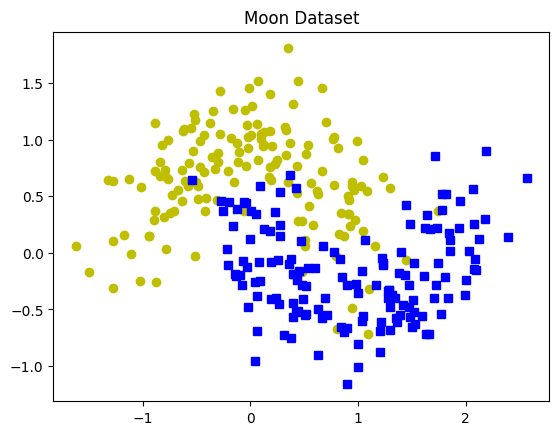

In [50]:
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("Moon Dataset")
plt.show()

In [52]:
tree_clf_1 = DecisionTreeClassifier()
tree_clf_1.fit(Xm, ym)

DecisionTreeClassifier()

In [53]:
tree_clf_2 = DecisionTreeClassifier(max_depth=2)
tree_clf_2.fit(Xm, ym)

DecisionTreeClassifier(max_depth=2)

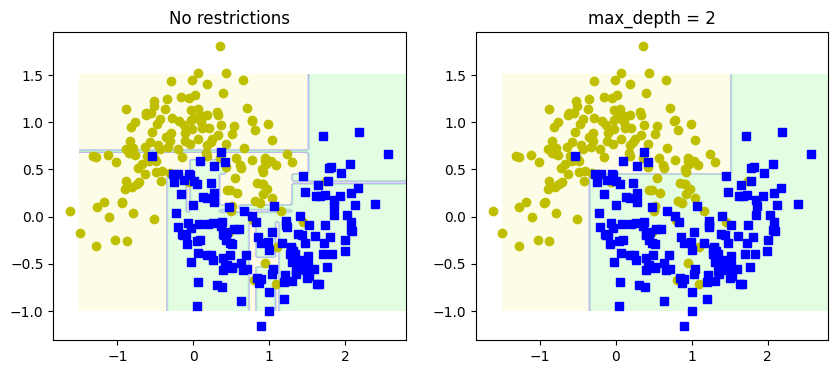

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plot_decision_boundary(tree_clf_1, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("No restrictions")

plt.sca(axes[1])
plot_decision_boundary(tree_clf_2, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("max_depth = {}".format(tree_clf_2.max_depth))

plt.show()

It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

## Regression
Decision Trees are also capable of performing regression tasks. Consider for example a noisy quadratic dataset:

In [56]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2 + np.random.randn(m, 1) / 10

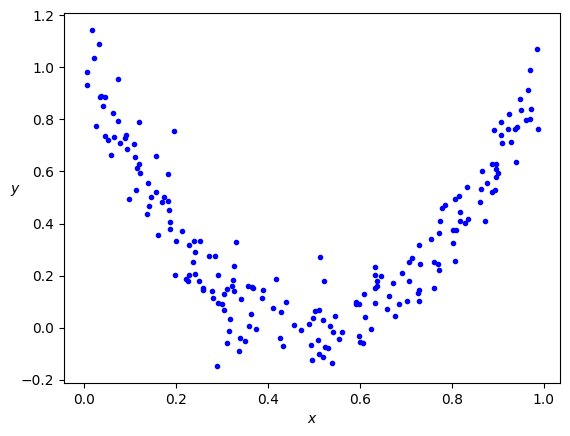

In [59]:
plt.plot(X, y, "b.")
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.show()

Let’s build a tree using Scikit-Learn’s **DecisionTreeRegressor** class, training it on a noisy quadratic dataset, with max_depth=2

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_1 = DecisionTreeRegressor(max_depth=2)
tree_reg_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

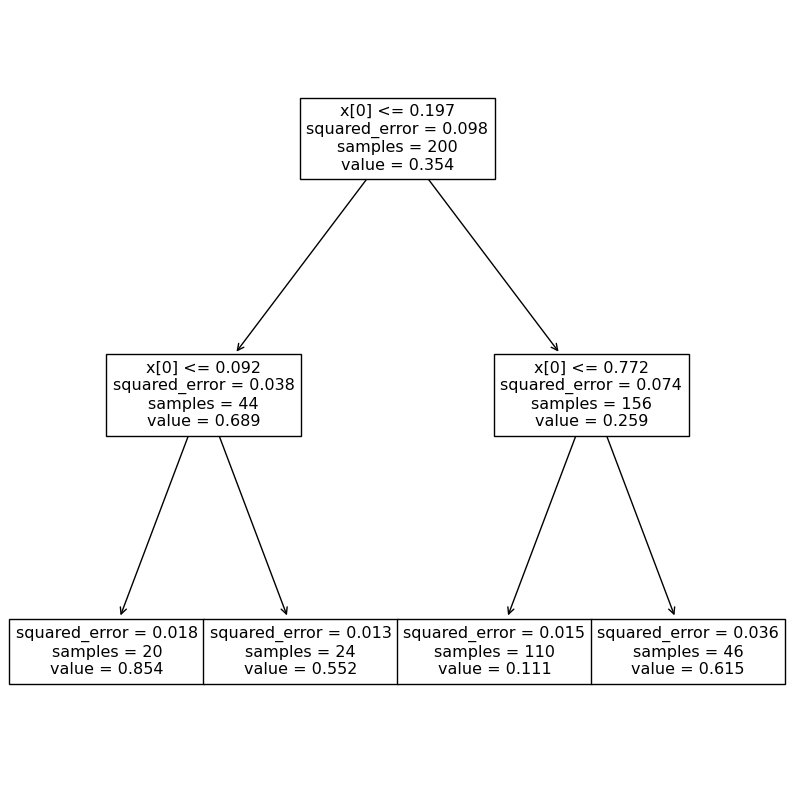

In [65]:
fig = plt.figure(figsize=(10,10))
plot = sklearn.tree.plot_tree(tree_reg_1)

This tree instead of predicting a class in each node, **it predicts a value**. For example, suppose we want to make a prediction for a new instance with $x=0.6$, we traverse the tree starting at the root, and we reach the leaf node that predicts value=0.111. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances. We can show the prediction also enlarging che max_depth value:

In [66]:
tree_reg_2 = DecisionTreeRegressor(max_depth=3)
tree_reg_2.fit(X, y)

DecisionTreeRegressor(max_depth=3)

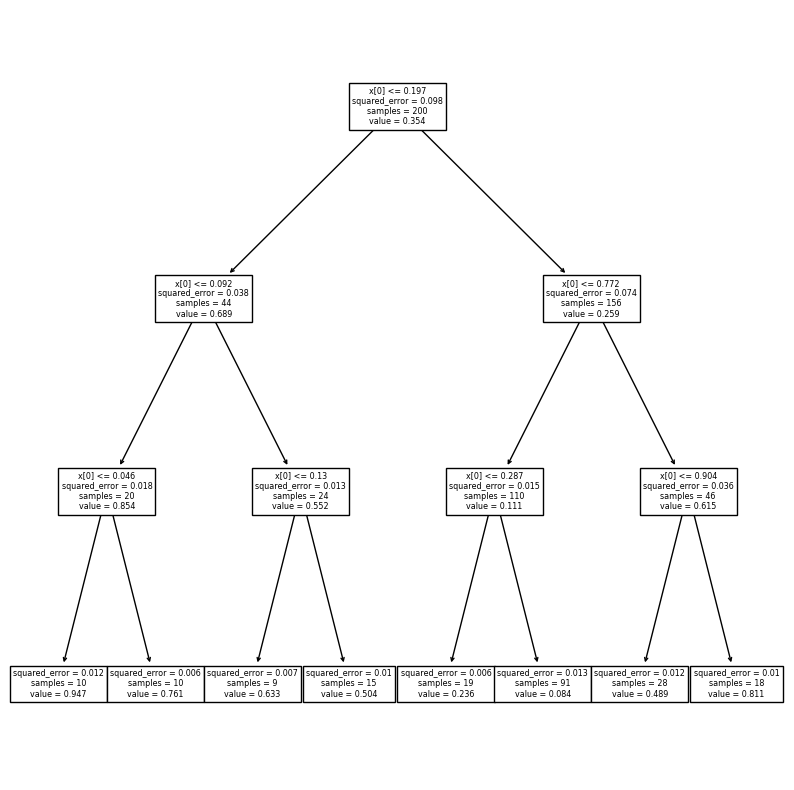

In [63]:
fig = plt.figure(figsize=(10,10))
plot = sklearn.tree.plot_tree(tree_reg_2)

We can visualize visualize the regression predictions made by the tree model over a specified range of values:

In [68]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

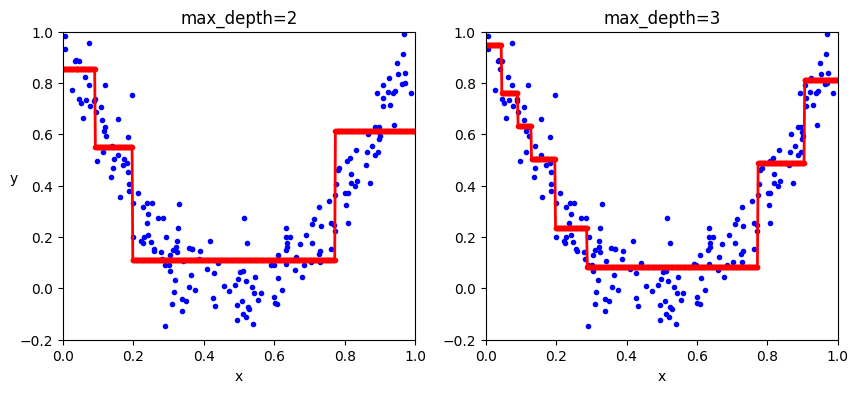

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plot_regression_predictions(tree_reg_1, X, y)
plt.title("max_depth=2")

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("x")
plot_regression_predictions(tree_reg_2, X, y)
plt.title("max_depth=3")

plt.show()

Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value. The CART algorithm works mostly the same way as earlier, except that **instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE**:

$\displaystyle J(k,t_k)=\frac{m_\text{left}}{m}\text{MSE}_\text{left}+\frac{m_\text{right}}{m}\text{MSE}_\text{right}$

where

$\displaystyle \text{MSE}_\text{node}=\sum\limits_{i\in\text{node}}(\hat{y}_\text{node}-y^{(i)})^2$

$\displaystyle \hat{y}_\text{node}=\frac{1}{m_\text{node}}\sum\limits_{i\in\text{node}}y^{(i)}$


Like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), we get predictions obviously overfitting the training set very badly. Just setting min_samples_leaf=10 results in a much more reasonable model.

In [73]:
tree_reg_3 = DecisionTreeRegressor()
tree_reg_3.fit(X, y)

DecisionTreeRegressor()

In [74]:
tree_reg_4 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg_4.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=10)

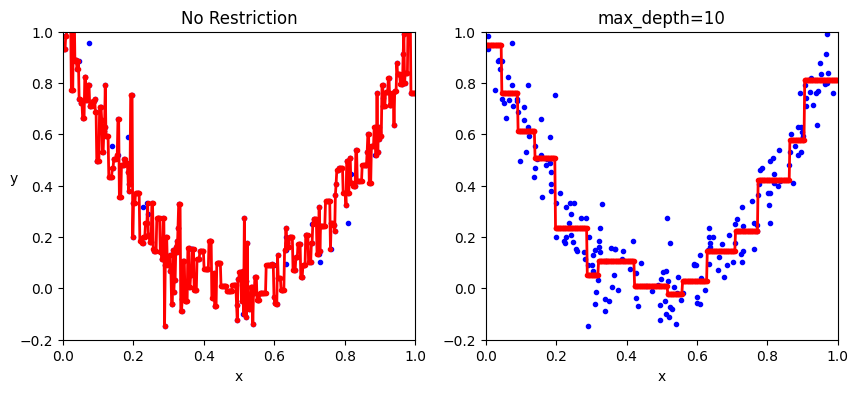

In [75]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plot_regression_predictions(tree_reg_3, X, y)
plt.title("No Restriction")

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("x")
plot_regression_predictions(tree_reg_4, X, y)
plt.title("max_depth=10")

plt.show()

## Instability

Decision Trees are **simple to understand and interpret**, **easy to use**, **versatile**, and **powerful**. However, they have limitations. They love **orthogonal decision boundaries** (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, consider a simple linearly separable dataset, a Decision Tree can split it easily:

In [76]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

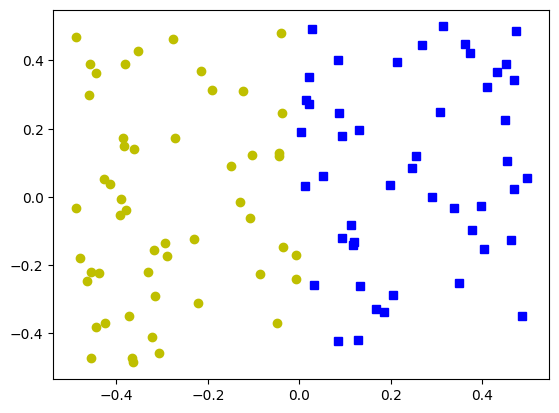

In [77]:
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "yo")
plt.plot(Xs[:, 0][ys==2], Xs[:, 1][ys==2], "bs")
plt.show()

In [78]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(Xs, ys)

DecisionTreeClassifier()

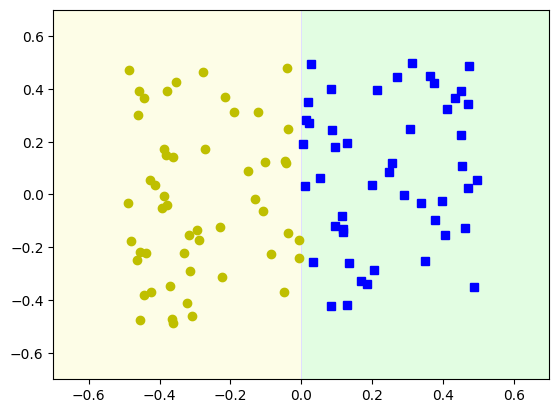

In [79]:
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "yo")
plt.plot(Xs[:, 0][ys==2], Xs[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.show()

But if we rotate the dataset: 

In [80]:
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

In [82]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(Xsr, ys)

DecisionTreeClassifier()

The decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model will not generalize well.

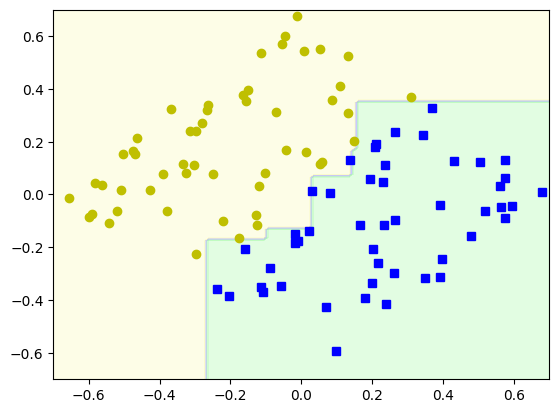

In [83]:
plt.plot(Xsr[:, 0][ys==0], Xsr[:, 1][ys==0], "yo")
plt.plot(Xsr[:, 0][ys==2], Xsr[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.show()

Moreover, Decision Tree are very **sensitive to small variations in the training data**. Random Forests can limit this instability by averaging predictions over many trees. For example, if we just remove the widest Iris versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, we may get a really different model.

In [84]:
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

In [85]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

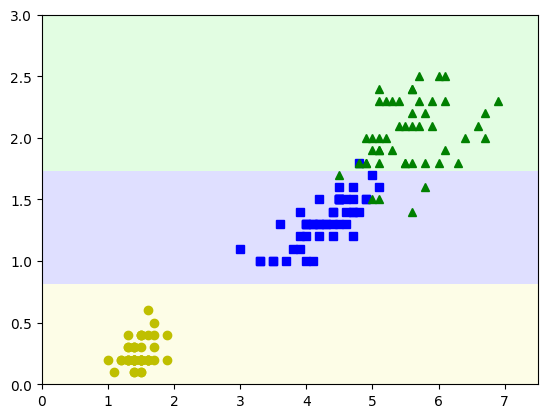

In [86]:
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.show()

## Exercise

**1 - Train and fine-tune a Decision Tree for the moons dataset by following these steps:** 
- **(a) use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset;** 
- **(b) use train_test_split() to split the dataset into a training set and a test set;** 
- **(c) use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier;** 
- **(d) train it on the full training set using these hyperparameters, and measure your model’s performance on the test set.**

In [87]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=0, cv=3)
grid_search_cv.fit(X_train, y_train)

print(grid_search_cv.best_estimator_)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)


In [90]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)

accuracy_score(y_test, y_pred)

0.8695

**2 - Grow a "forest" by following these steps:** 
- **(a) continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly;** 
- **(b) train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise, evaluate these 1,000 Decision Trees on the test set (since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy);** 
- **(c) Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction;** 
- **(d) evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model**

In [95]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [96]:
from sklearn.base import clone
    
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
print(np.mean(accuracy_scores))  

0.805475


In [98]:
from scipy.stats import mode

Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872